In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set(rc={'figure.figsize': (9,6)})

In [9]:
submissions_data = pd.read_csv('submissions_data_train.csv')
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [10]:
events_data = pd.read_csv('event_data_train.csv')
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [54]:
# решение без потерь
users_events_data = events_data.pivot_table(index='user_id', 
                       columns='action', 
                       values='step_id', 
                       aggfunc='count', 
                       fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [7]:
users_scores = submissions_data.pivot_table(index='user_id', 
                       columns='submission_status', 
                       values='step_id', 
                       aggfunc='count', 
                       fill_value=0).reset_index()

In [29]:
# id Карпова первый
users_scores.sort_values(by='correct', ascending=False)

submission_status,user_id,correct,wrong
439,1046,421,513
2099,5552,186,93
6415,17135,168,177
2344,6183,142,65
3208,8461,135,42
...,...,...,...
551,1321,0,2
9778,26349,0,1
3559,9422,0,1
5014,13408,0,2


In [30]:
gaps_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values
gaps_data = pd.Series(np.concatenate(gaps_data, axis=0))
gaps_data = gaps_data / (24 * 60 *60)

<Axes: >

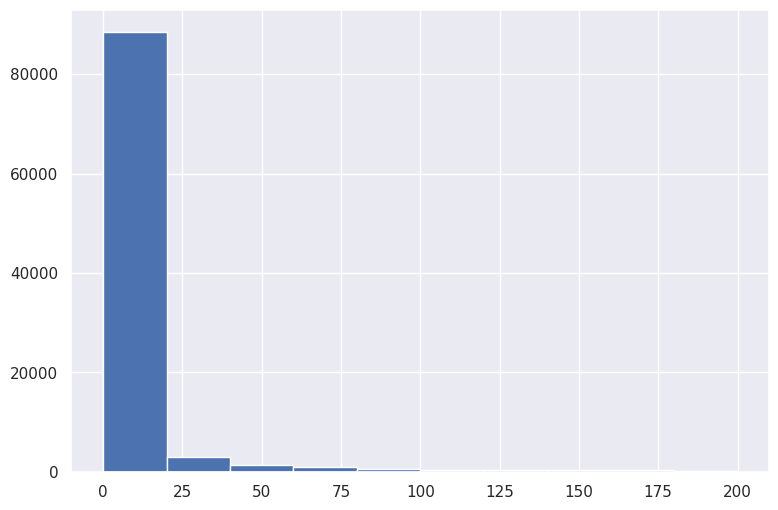

In [31]:
gaps_data[gaps_data < 200].hist()

In [32]:
gaps_data.quantile(0.90)

18.325995370370403

In [33]:
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [38]:
users_data = events_data.groupby('user_id', as_index=False).agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [41]:
now = 1526772811
drop_out_treshhold = 30 * 24 * 60 * 60

In [42]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshhold

In [43]:
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [55]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')
users_data.fillna(0, inplace=True)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct_x,wrong_x,correct_y,wrong_y,correct,wrong
0,1,1472827464,True,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1519226966,True,2.0,0.0,2.0,0.0,2.0,0.0
2,3,1444581588,True,29.0,23.0,29.0,23.0,29.0,23.0
3,5,1499859939,True,2.0,2.0,2.0,2.0,2.0,2.0
4,7,1521634660,True,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
users_data = users_data.merge(users_events_data, on='user_id', how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct_x,wrong_x,correct_y,wrong_y,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,2.0,0.0,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,29.0,23.0,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,2.0,2.0,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,1


In [60]:
users_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [62]:
users_data = users_data.merge(users_days, on='user_id', how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct_x,wrong_x,correct_y,wrong_y,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,2.0,0.0,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,29.0,23.0,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,2.0,2.0,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,1


In [63]:
users_data.user_id.nunique()

19234

In [64]:
events_data.user_id.nunique()

19234

In [66]:
users_data['passed_corce'] = users_data.passed > 170
users_data.head()

,user_id,last_timestamp,is_gone_user,correct_x,wrong_x,correct_y,wrong_y,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_corce
0,1,1472827464,True,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,2.0,0.0,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,29.0,23.0,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,2.0,2.0,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,1,1,False


In [67]:
users_data.groupby('passed_corce').count()

,user_id,last_timestamp,is_gone_user,correct_x,wrong_x,correct_y,wrong_y,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_corce,,,,,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [69]:
100 * 1425 / 17809

8.001572238755685